In [1]:
#pip install findspark

In [2]:
# pip install pyspark

In [3]:
import findspark
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date, timedelta, datetime
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark  
from pyspark.context import SparkContext
from pyspark.ml.feature import StringIndexer
from sklearn.metrics import f1_score, recall_score, precision_score
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, LinearSVC


In [4]:
spark=SparkSession.builder\
    .master("local")\
    .appName("Spark hw")\
    .config("spark.executer.memory","16gb")\
    .getOrCreate()
sc=spark.sparkContext

22/12/06 11:33:08 WARN Utils: Your hostname, Chads-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.2 instead (on interface en0)
22/12/06 11:33:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/06 11:33:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df=spark.read.csv("churn.csv",header=True,sep=",",inferSchema=True)

In [6]:
df.show()

22/12/06 11:33:16 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+---+-------------------+----+--------------+---------------+-----+---------+-----+
|_c0|              Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+-------------------+----+--------------+---------------+-----+---------+-----+
|  0|   Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|      Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|        Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|      Phillip White|42.0|       8010.76|              0| 6.71|  

In [7]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [8]:
df=df.withColumnRenamed("_c0","index")

In [9]:
df.show()

22/12/06 11:33:16 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+-----+-------------------+----+--------------+---------------+-----+---------+-----+
|index|              Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+-----+-------------------+----+--------------+---------------+-----+---------+-----+
|    0|   Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|    1|      Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|    2|        Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|    3|      Phillip White|42.0|       8010.76|          

In [10]:
# all columns converted to lowercase
df=df.toDF(*[c.lower() for c in df.columns])

In [11]:
df.show()

22/12/06 11:33:16 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+-----+-------------------+----+--------------+---------------+-----+---------+-----+
|index|              names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------------+----+--------------+---------------+-----+---------+-----+
|    0|   Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|    1|      Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|    2|        Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|    3|      Phillip White|42.0|       8010.76|          

In [12]:
df.count()

900

In [13]:
df.select("names").distinct().count()

899

In [14]:
#Do you have the same name?
df.groupBy("names").count().sort("count",ascending=False).show(3)

+-------------+-----+
|        names|count|
+-------------+-----+
|Jennifer Wood|    2|
| Patrick Bell|    1|
|Chelsea Marsh|    1|
+-------------+-----+
only showing top 3 rows



In [15]:
df.filter(df.names=="Jennifer Wood").show()

22/12/06 11:33:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|   22|Jennifer Wood|35.0|       9381.12|              1| 6.78|     11.0|    1|
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [16]:
# Access to index
df.where(df.index==439).show()

22/12/06 11:33:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [17]:
#df.filter(df.names=="Chelsea Marsh").show()
df.where(df.names=="Chelsea Marsh").show()


22/12/06 11:33:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|  479|Chelsea Marsh|41.0|       9552.57|              0| 3.81|      8.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [18]:
df.where(df.index==479).select("names").show()

22/12/06 11:33:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names
 Schema: _c0, Names
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+-------------+
|        names|
+-------------+
|Chelsea Marsh|
+-------------+



In [19]:
df.where(df.index==479).collect()[0]["names"]

22/12/06 11:33:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv


'Chelsea Marsh'

In [20]:
df.describe().show()

22/12/06 11:33:19 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|             index|        names|              age|   total_purchase|   account_manager|            years|         num_sites|              churn|
+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|               900|          900|              900|              900|               900|           

In [21]:
#Show all columns description
df.select('age','total_purchase','account_manager','years','num_sites','churn').describe().show()

+-------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|              age|   total_purchase|   account_manager|            years|         num_sites|              churn|
+-------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|              900|              900|               900|              900|               900|                900|
|   mean|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|             22.0|            100.0|                 0|              1.0|               3.0|                  0|
|    max|             65.0|         18026.01|                 1|             9.15|              14.0|                  1|
+-------+---------------

In [22]:
df.describe().toPandas().transpose()

22/12/06 11:33:20 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv


,0,1,2,3,4
summary,count,mean,stddev,min,max
index,900,449.5,259.95191863111916,0,899
names,900,None,None,Aaron King,Zachary Walsh
age,900,41.81666666666667,6.127560416916251,22.0,65.0
total_purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
account_manager,900,0.4811111111111111,0.4999208935073339,0,1
years,900,5.27315555555555,1.274449013194616,1.0,9.15
num_sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
churn,900,0.16666666666666666,0.3728852122772358,0,1


In [23]:
import seaborn as sns

In [24]:
pandas_df=df.drop("index","names").toPandas()

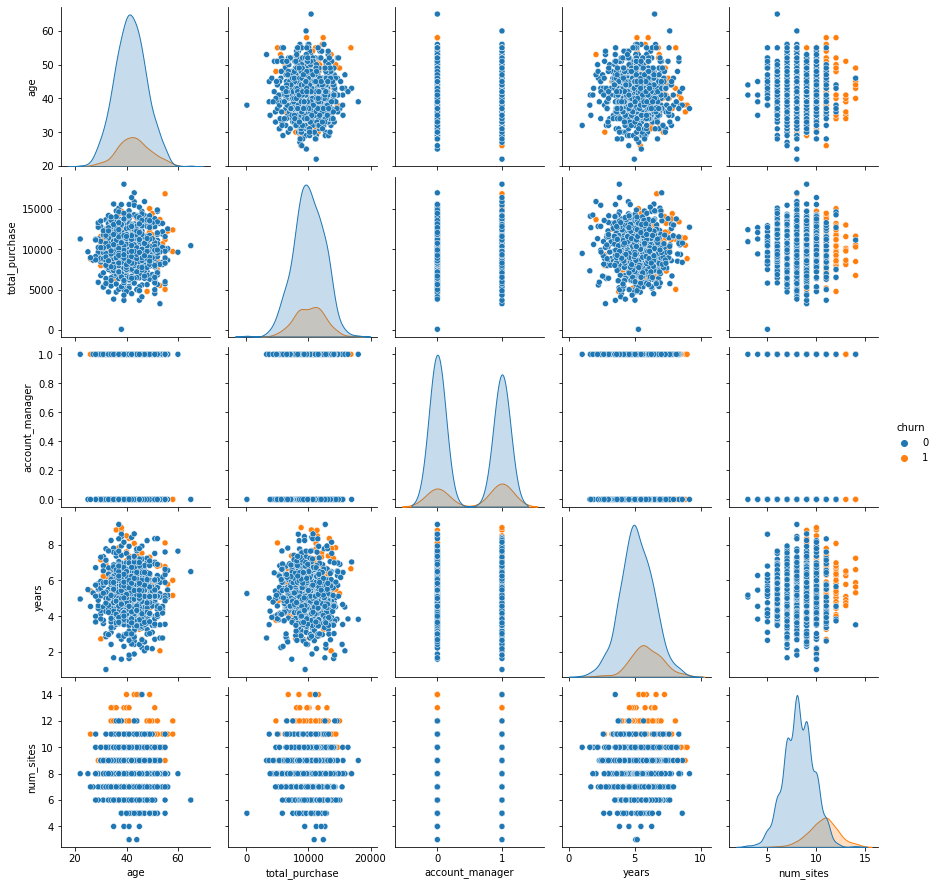

In [25]:
sns.pairplot(pandas_df,hue="churn");

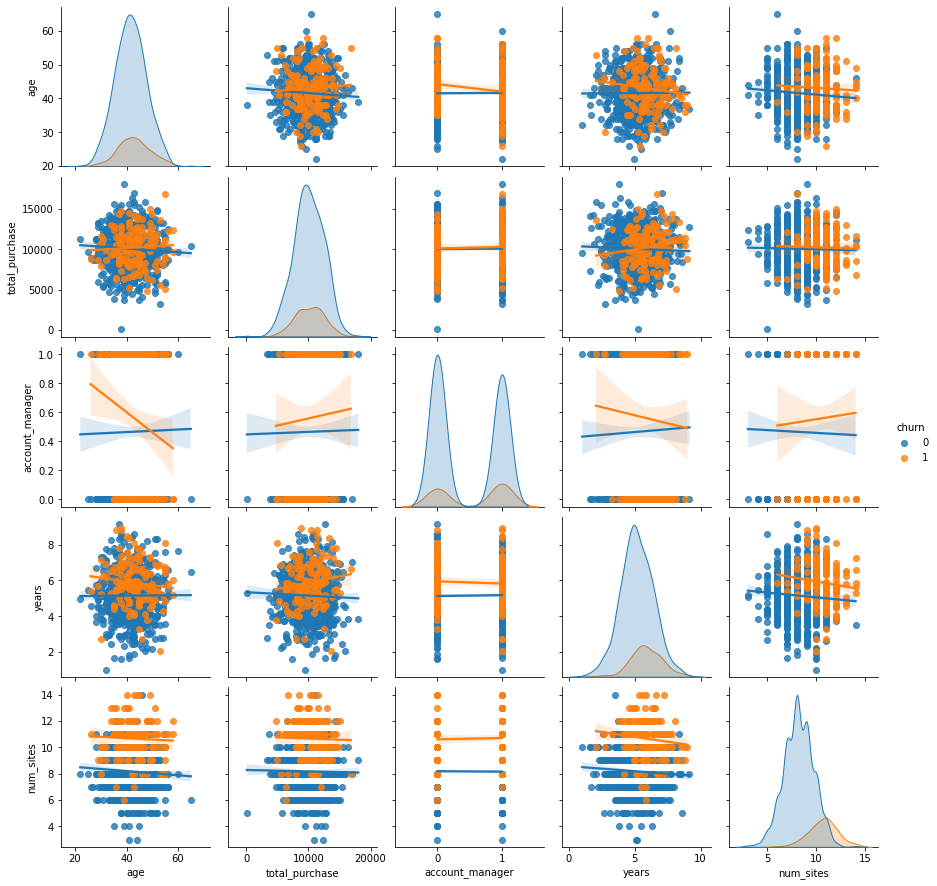

In [26]:
sns.pairplot(pandas_df,hue="churn",kind="reg");

In [28]:
df=df.dropna()

In [30]:
df=df.withColumn("age_sqrt",df.age**2)

In [31]:
df.show(3)

22/12/06 11:35:20 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|age_sqrt|
+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|  1764.0|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|  1681.0|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|  1444.0|
+-----+--------------

In [32]:
# Assign the dependent variable as label
from pyspark.ml.feature import StringIndexer
stringIndexer=StringIndexer(inputCol="churn",outputCol="label")

In [33]:
indexed=stringIndexer.fit(df).transform(df)

22/12/06 11:35:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv


In [34]:
indexed.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_sqrt', 'double'),
 ('label', 'double')]

In [35]:
df=indexed.withColumn("label",indexed.label.cast("integer"))

In [36]:
df.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_sqrt', 'double'),
 ('label', 'int')]

In [37]:
from pyspark.ml.feature import VectorAssembler
bag_deg=['age','total_purchase','account_manager','years','num_sites']

In [38]:
vectorAssembler=VectorAssembler(inputCols=bag_deg,outputCol="features")

In [39]:
features_deg=vectorAssembler.transform(df)

In [40]:
final_df=features_deg.select("features","label")
final_df.show()

22/12/06 11:36:53 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
|[30.0,11575.37,1....|    1|
|[45.0,8771.02,1.0...|    1|
|[45.0,8988.67,1.0...|    1|
|[40.0,8283.32,1.0...|    1|
|[41.0,6569.87,1.0...|    1|
|[38.0,10494.82,1....|    1|
|[45.0,8213.41,1.0...|

In [41]:
splits=final_df.randomSplit([0.7,0.3])

In [42]:
train_df=splits[0]
test_df=splits[1]

In [43]:
train_df.count(),test_df.count()

22/12/06 11:37:24 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
22/12/06 11:37:24 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv


(660, 240)

In [44]:
from pyspark.ml.classification import GBTClassifier

In [45]:
gbm=GBTClassifier(maxIter=10,featuresCol="features",labelCol="label")

In [46]:
gbm_model=gbm.fit(train_df)

22/12/06 11:37:49 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
22/12/06 11:37:49 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
22/12/06 11:37:49 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years,

In [47]:
y_pred=gbm_model.transform(test_df)

In [48]:
y_pred.show(10)

22/12/06 14:35:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
22/12/06 14:35:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/06 14:35:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/12/06 14:35:27 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+----------------

In [49]:
ac=y_pred.select("label","prediction")
ac.show(5)

22/12/06 14:35:43 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 5 rows



In [50]:
ac.filter(ac.label==ac.prediction).count()/ac.count()

22/12/06 14:35:52 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
22/12/06 14:35:52 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv


0.8458333333333333

In [51]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator

In [52]:
evaluator=BinaryClassificationEvaluator()
pramGrid=(ParamGridBuilder()
         .addGrid(gbm.maxDepth,[2,4,6])
         .addGrid(gbm.maxBins,[20,30])
         .addGrid(gbm.maxIter,[10,20])
         .build())

cv=CrossValidator(estimator=gbm,estimatorParamMaps=pramGrid,evaluator=evaluator,numFolds=10)

In [53]:
cv_model=cv.fit(train_df)
y_pred=cv_model.transform(test_df)

22/12/06 14:36:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
22/12/06 14:36:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
22/12/06 14:37:00 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years,

22/12/06 14:41:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
22/12/06 14:41:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
22/12/06 14:41:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years,

In [54]:
ac=y_pred.select("label","prediction")

In [55]:
ac.filter(ac.label==ac.prediction).count()/ac.count()

22/12/06 14:41:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv
22/12/06 14:41:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv


0.875

In [56]:
evaluator.evaluate(y_pred)

22/12/06 14:43:21 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/chadsaglam/AI_BC/Project%20Based%20Learning%20Level%202/Big%20Data%20Machine%20Learning%20Classification%20with%20Spark/churn.csv


0.8883760683760683